# DNN estimator architectures and their performance evaluation


## Load Data

In [1]:
import pandas as pd

from data import load_data_selected_features
from pipelines_selected_features import pipeline

train_data, additional_train_data, test_data = load_data_selected_features()
all_train_data = pipeline.fit_transform(pd.concat([train_data, additional_train_data]))

# cut the data into train, additional train and test
train_data = all_train_data.loc[train_data.index]
additional_train_data = all_train_data.loc[additional_train_data.index]

X_train = train_data.drop(columns=['bg+1:00'])
y_train = train_data['bg+1:00']

X_additional_train = additional_train_data.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data['bg+1:00']

# MA-01 (used in v4.0)

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


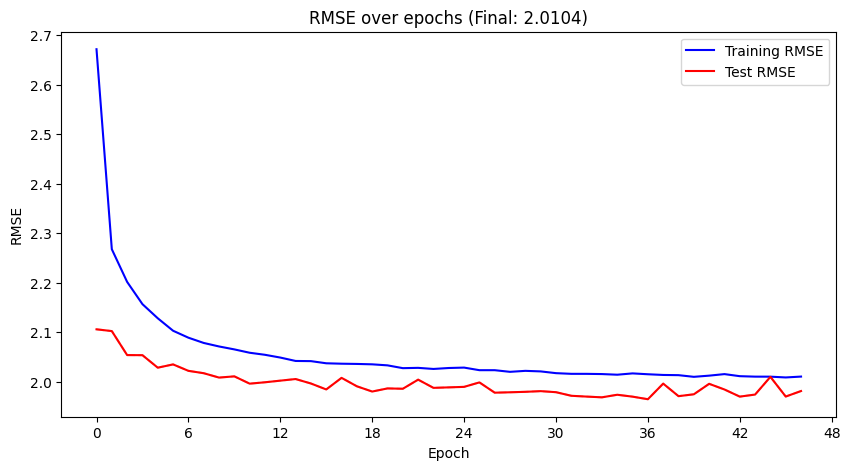

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


score, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## MA-02
### Increased Neurons in Dense Layers

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step


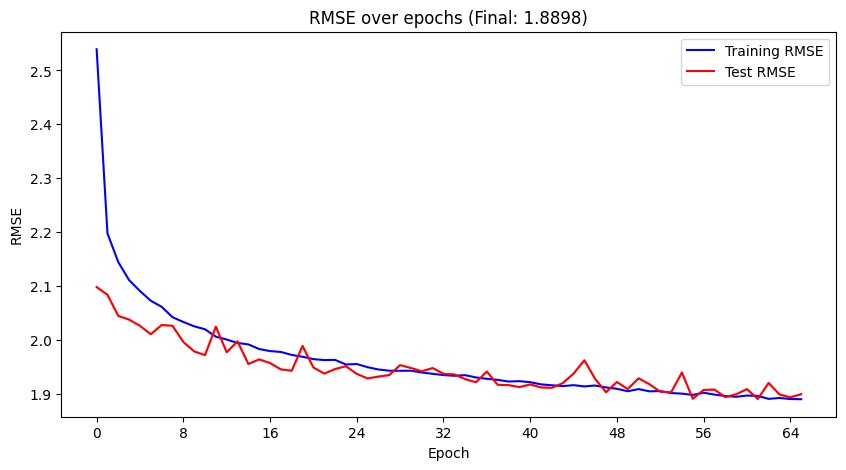

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        # Input layer
        Input(shape=(input_dimension,)),

        # First dense block
        Dense(512, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),  # Slightly reduced dropout for better capacity

        # Second dense block
        Dense(256, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),

        # Third dense block
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Fourth dense block (new)
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='linear')  # Regression output
    ])

    # Compile the model
    dnn.compile(
        optimizer=Adam(learning_rate=0.001),  # Retained learning rate
        loss='mse',  # Mean Squared Error for regression
        metrics=[rmse]  # Custom RMSE metric
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Adjusted Layer Sizes with More Nonlinearity

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


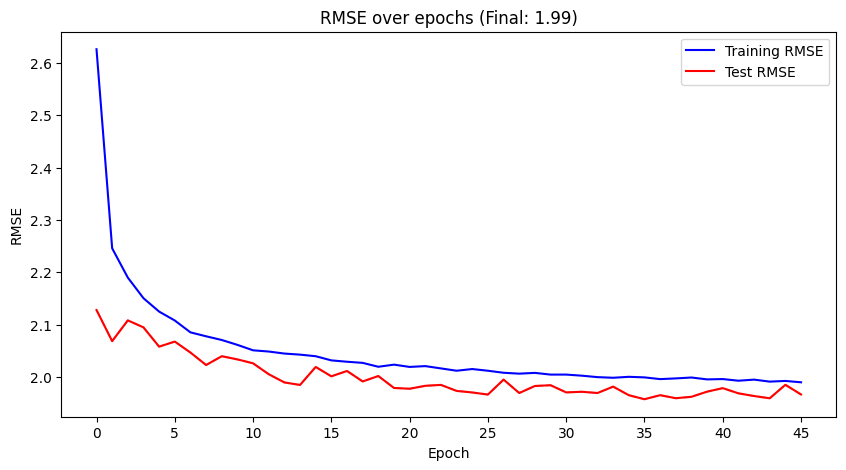

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Switched to Exponential Linear Unit (ELU) activation function

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step


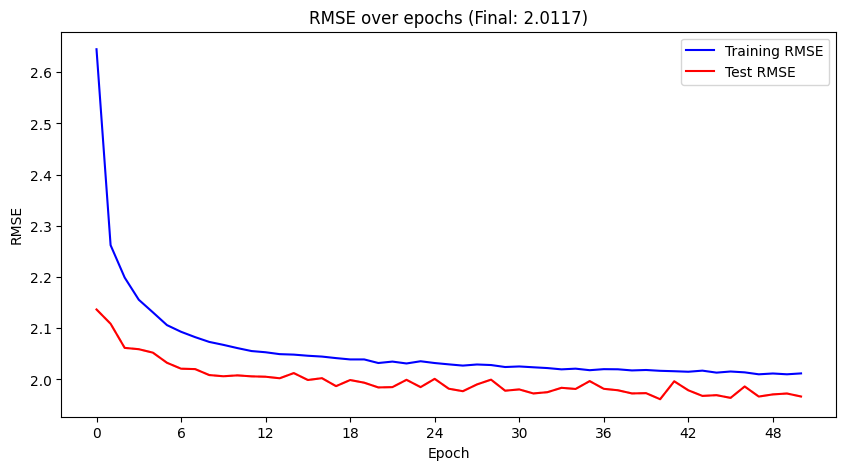

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='elu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='elu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='elu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Residual Connections (Inspired by ResNet)

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step


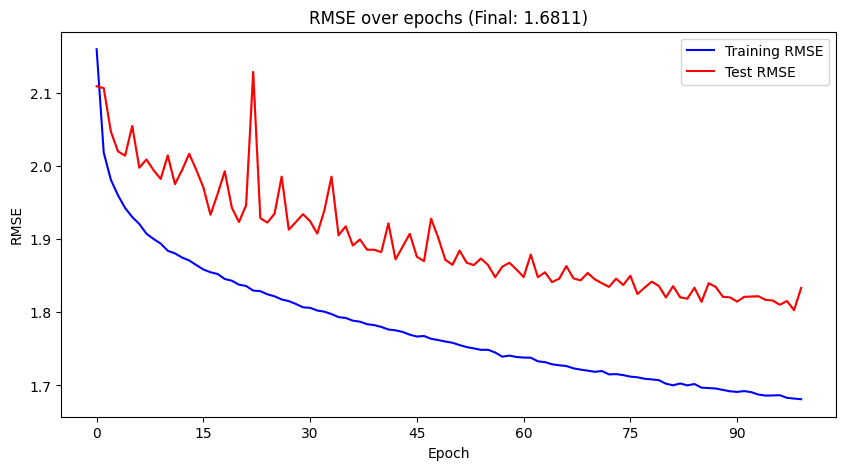

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    def residual_block(input_layer, units):
        # First dense layer
        dense1 = Dense(units, activation='relu')(input_layer)
        batchnorm1 = BatchNormalization()(dense1)
        # Second dense layer
        dense2 = Dense(units, activation='relu')(batchnorm1)
        batchnorm2 = BatchNormalization()(dense2)
        # Add projection if shapes don't match
        if input_layer.shape[-1] != units:
            input_layer = Dense(units)(input_layer)  # Project input to match dimensions
        # Add the skip connection
        return Add()([input_layer, batchnorm2])

    input_layer = Input(shape=(input_dimension,))
    residual1 = residual_block(input_layer, 128)
    residual2 = residual_block(residual1, 64)
    residual3 = residual_block(residual2, 32)

    output = Dense(1, activation='linear')(residual3)

    dnn = Model(inputs=input_layer, outputs=output)

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

### Advanced Optimizer: Learning Rate Scheduler

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
Final estimator RMSE: 1.990603140330478
Final estimator R2: 0.6294339761538857
Final estimator MSE: 3.962577686006257
Final estimator MAE: 1.4819833631802304


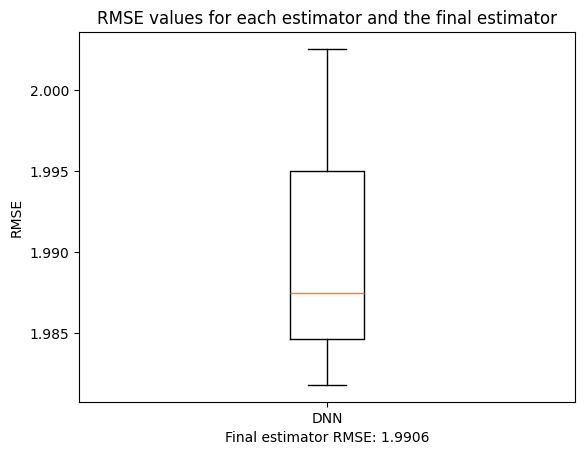

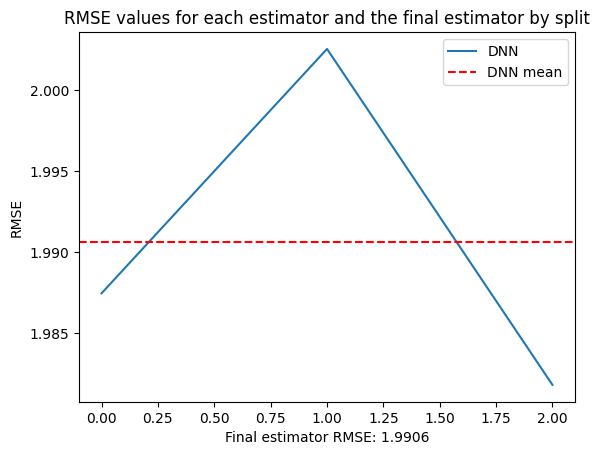

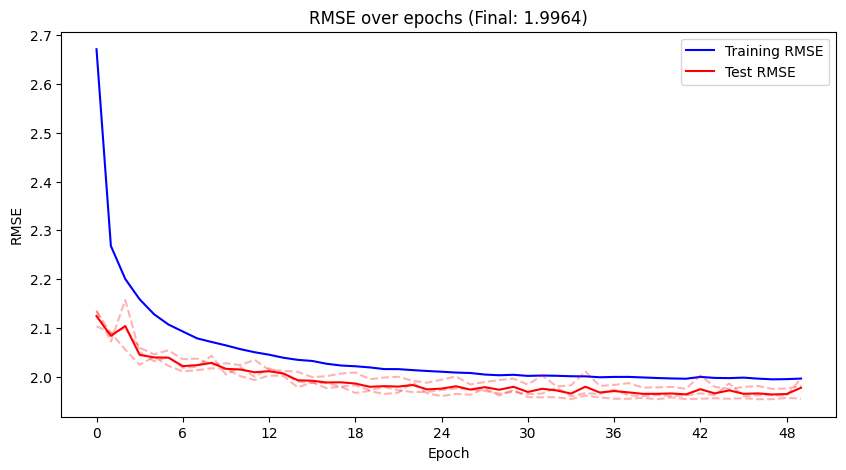

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9


lr_scheduler = LearningRateScheduler(scheduler)


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, callbacks=[lr_scheduler], verbose=0)
get_history_line_chart(histories).show()

## Hybrid Model (Combining Linear and Nonlinear Components)



1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
Final estimator RMSE: 1.9748976875321886
Final estimator R2: 0.6352548080786545
Final estimator MSE: 3.900302588715301
Final estimator MAE: 1.4622376640097965


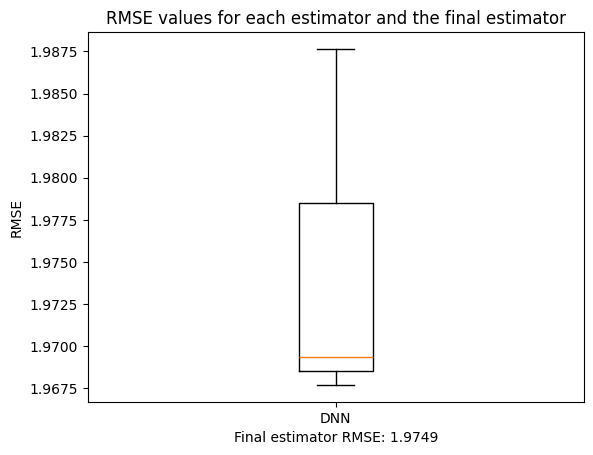

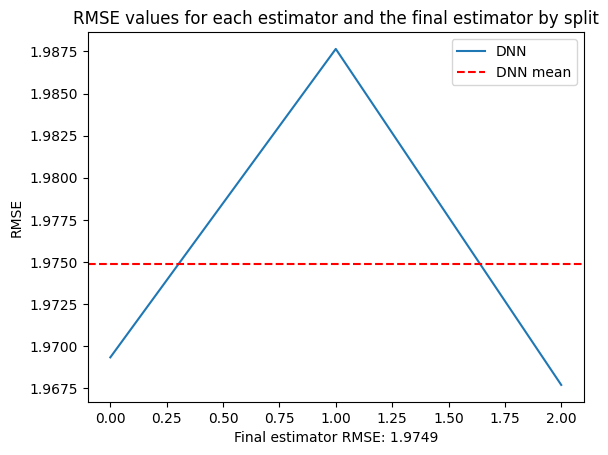

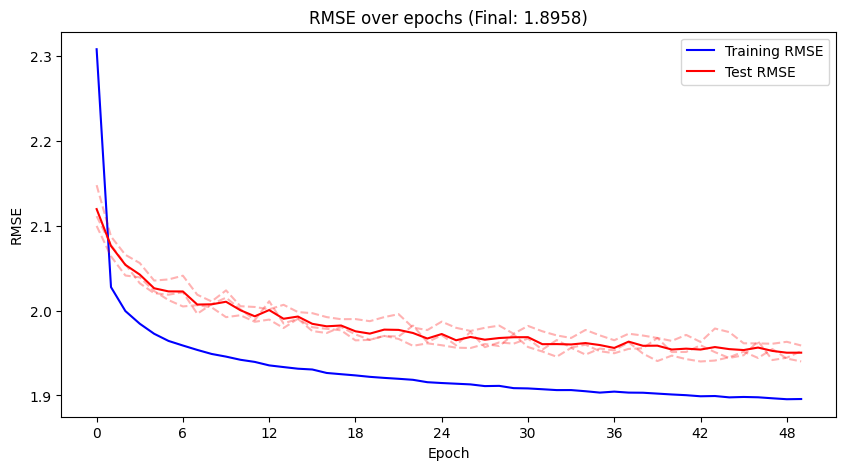

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    input_layer = Input(shape=(input_dimension,))

    # Linear component
    linear = Dense(1, activation='linear')(input_layer)

    # Nonlinear component
    nonlinear = Dense(128, activation='relu')(input_layer)
    nonlinear = BatchNormalization()(nonlinear)
    nonlinear = Dropout(0.3)(nonlinear)
    nonlinear = Dense(64, activation='relu')(nonlinear)
    nonlinear = BatchNormalization()(nonlinear)
    nonlinear = Dropout(0.3)(nonlinear)
    nonlinear = Dense(32, activation='relu')(nonlinear)
    nonlinear = BatchNormalization()(nonlinear)

    # Merge linear and nonlinear components
    merged = Concatenate()([linear, nonlinear])
    output = Dense(1, activation='linear')(merged)

    dnn = Model(inputs=input_layer, outputs=output)

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Others Optimizers

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


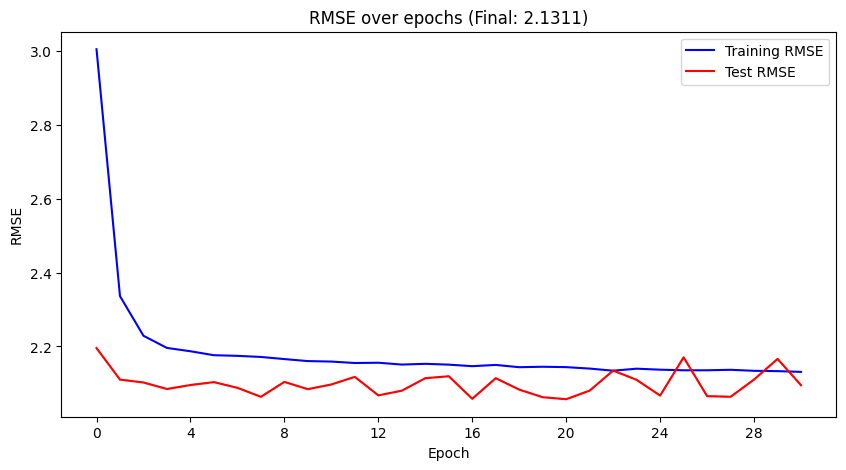

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        # Input Layer
        Input(shape=(input_dimension,)),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        # Hidden Layer 1
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        # Hidden Layer 2    
        Dense(32),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        # Output Layer
        Dense(1, activation='linear')
    ])

    dnn.compile(optimizer='adam', loss='mse', metrics=[rmse])

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Evaluate a DNN Model with Early Stopping

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='linear')
    ])

    dnn.compile(optimizer='adam', loss='mse', metrics=[rmse])

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_rmse_boxplot_chart(score).show()
get_rmse_line_chart(score).show()
get_history_line_chart(histories).show()

## Simple and wide model

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Shallow with Feature Compression

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart
from tensorflow.keras.optimizers import Adam


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(create_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

### Wider Network (No Gradual Reduction)

In [ ]:

def get_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(get_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

### Wide and Deep Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate


def get_dnn_model(input_dimension: int):
    input_layer = Input(shape=(input_dimension,))
    wide = Dense(128, activation='relu')(input_layer)  # Wide component
    deep = Dense(128, activation='relu')(input_layer)
    deep = Dense(64, activation='relu')(deep)
    deep = Dense(32, activation='relu')(deep)

    merged = Concatenate()([wide, deep])
    output_layer = Dense(1, activation='linear')(merged)

    dnn = Model(inputs=input_layer, outputs=output_layer)

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


_, histories = calculate_dnn_performance(get_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()

## Regularized Wide & Deep Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from model_performance_calculations import calculate_dnn_performance, get_rmse_boxplot_chart, get_rmse_line_chart, get_history_line_chart


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def get_dnn_model(input_dimension: int):
    input_layer = Input(shape=(input_dimension,))

    # Wide part of the model with L2 regularization and Dropout
    wide = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    wide = Dropout(0.5)(wide)
    wide = BatchNormalization()(wide)

    # Deep part of the model with L2 regularization, Dropout, and BatchNormalization
    deep = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    deep = Dropout(0.5)(deep)
    deep = BatchNormalization()(deep)

    deep = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(deep)
    deep = Dropout(0.5)(deep)
    deep = BatchNormalization()(deep)

    deep = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(deep)
    deep = Dropout(0.5)(deep)
    deep = BatchNormalization()(deep)

    # Merge the wide and deep components
    merged = Concatenate()([wide, deep])

    # Output layer
    output_layer = Dense(1, activation='linear')(merged)

    # Create the model
    dnn_model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    dnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn_model


_, histories = calculate_dnn_performance(get_dnn_model, X_train, y_train, X_additional_train, y_additional_train, n_splits=1, epochs=100, verbose=0)
get_history_line_chart(histories).show()